## Importamos las librerias

In [1]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
import random as rn 
import tensorflow as tf 
import keras_tuner

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

rn.seed(14)
tf.random.set_seed(14)


## Procesamiento de datos

In [2]:
# Lista de las carpetas, la direccion donde esta las carpetas
carpetas= ['negativo', 'positivo']
Direccion= 'G:\Mi unidad\Colab Notebooks\Python\Proyecto_final\Proyecto de grietas'
lista= []
lista_img= []
x_image= []
y_label= []
resize= 200

"""Iteramos los nombres de las carpetas con la Direccion
   Para sacar la lista de los imagenes de cada una de las carpetas que van a hacer nuestras x
   sacamos cada una de las imagenes con sus ruta
"""
for i in carpetas:
    path_full= os.path.join(Direccion, i)
    list_imagen= os.listdir(path_full)
    list_path_img= [os.path.join(path_full, i) for i in list_imagen]
    lista.append(list_path_img)


# Aplanamos las listas para que quede una sola lista con todas las imagenes
for i in lista:
   for j in i:
      lista_img.append(j)

# Mezclamos las imagenes para que todo quede revuelto   
rn.shuffle(lista_img)



"""Vamos a tratar nuestras imagenes: poniendo escala de grises y estabreciendo una dimencion 200*200, normalizamos
   Luego sacamos de cada imagen el nombre de la carpeta para nuestra etiquetas labels y la imagenes tratadas en x
"""

for i in lista_img:
   imagen= cv2.imread(i)
   imagen= cv2.resize(imagen,(resize, resize))
   imagen= cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
   imagen= imagen/255
   x_image.append(imagen)
   y_label.append(os.path.basename(os.path.dirname(i)))


# agregamos una dimencion mas evez de tener (200,100,100) va a tener (200,100,100,1) es para el procesamiento de imagenes 
x_image = np.expand_dims(x_image, axis=-1)      

# Mapear las etiquetas a valores numéricos 
etiquetas_a_numeros = {"negativo": 0, "positivo": 1}
y_label = np.array([etiquetas_a_numeros[etiqueta] for etiqueta in y_label])



In [3]:

# Es para acomodar las imagenes para un mejor entrenamiento
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True,  
    vertical_flip=True,  
)

batch_size= 14

datagen.fit(x_image)


Dividimos nuestros datos en prueba y entrenamiento 

In [4]:
# Calculamos el 80 porciento de nuetros datos
numX= len(x_image)
num_train= int(numX*0.8)

# Separamos nuestros datos con la cantidad que nos dio arriba

# Datos de Entrenamiento
x_train= x_image[:num_train]
y_train= y_label[:num_train]

# Datos de Validacion
x_val= x_image[num_train:]
y_val= y_label[num_train:]

print("x de entrenamiento: ",len(x_train))
print("y de entrenamiento: ",len(y_train))
print("x de validacion: ",len(x_val))
print("y de validacion: ",len(y_val))


x de entrenamiento:  160
y de entrenamiento:  160
x de validacion:  40
y de validacion:  40


1


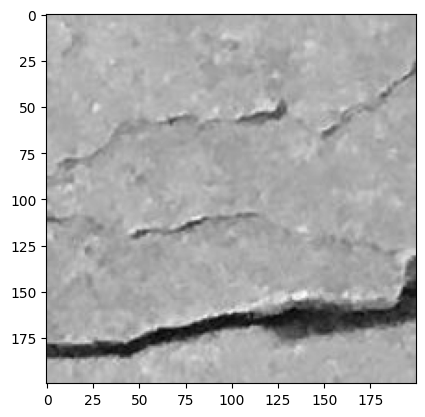

In [5]:
# Es para ver la etiqueta com sus imagen 
print(y_train[3])
plt.imshow(x_train[3], cmap='gray')


## Afinar los Hiper parametros usando keras tuner 

Esto nos ayuda a que cuando estemos jugando con nuestros hiper parametros hipper parametros no tengamos que hacer varios modelos para cada posible conbinacion

In [6]:
# Creamos una función con los diferentes hiperparámetros que vamos a usar 
def crear_modelo(hp):
    
    # Creamos el modelo 
    modelo = Sequential()
    
    # Agregamos la capa de entrada esa es fija con su maxpooling
    modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    
    # Vamos a agregar más capas convolucionales con su capa maxpooling 
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)):
        modelo.add(Conv2D(
            filters=hp.Int(f'conv{i+2}_filters', min_value=32, max_value=128, step=16),
            kernel_size=tuple(int(x) for x in hp.Choice(f'conv{i+2}_kernel', values=['2*2', '3*3', '4*4', '5*5']).split('*')),
            activation='relu'
        ))
        modelo.add(MaxPooling2D(pool_size=tuple(int(x) for x in hp.Choice(f'pool_size', values=['2*2','3*3','6*6']).split('*'))))
    
    # Aplanamos de lo que viene de nuestra capas 
    modelo.add(Flatten())
    
    # Capas Densas 
    cap_den = hp.Int('Capa_densa', min_value=1, max_value=3, step=1)
    for i in range(1, cap_den + 1):
        modelo.add(Dense(units=hp.Int(f'units_dense_{i}', min_value=32, max_value=512, step=32),
                         activation='relu'))
    
    # Capa de salida
    modelo.add(Dense(2, activation='softmax'))
    
    # Ajustamos el lr para nuestro compile 
    hp_lr = hp.Choice('Learning_rate', values=[0.01, 1e-2, 1e-3, 1e-7])
    
    # Compilamos nuestro modelo 
    modelo.compile(optimizer=Adam(learning_rate=hp_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return modelo



In [7]:
# Verificamos si la funcion construye el modelo correctamente 
crear_modelo(keras_tuner.HyperParameters())



In [8]:
"""Vamos a crear el afinador el que nos ayuda a afinar nuestros hiper parametros, bamos a escoger 
   areatoria mente varios hipper parametro los hipper parametro que mejor se nos acople ese sera 
   el que seleccionaremos al final, hay varios metodos que puedes usar 
"""

tuner= keras_tuner.RandomSearch(
    hypermodel= crear_modelo, # La funcion que creamos
    objective= "val_accuracy", # La matrica de desempeño en la acinacion
    max_trials= 10, # numero total de combinaciones a probar
    directory= "afinacion_red", # dereccion local donde se amacenara los resultados de cada modelo
    project_name= "trials", #sud direccion donde se amacenara los resultados de validacion de cada modelo
    overwrite= True, # para sub_escribir los directorios _ false nos deja sin borrar los entrenamientos
)



In [9]:
# Imprimir en pantalla el espacio de busqueda 
tuner.search_space_summary()


Search space summary
Default search space size: 7
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv2_kernel (Choice)
{'default': '2*2', 'conditions': [], 'values': ['2*2', '3*3', '4*4', '5*5'], 'ordered': False}
pool_size (Choice)
{'default': '2*2', 'conditions': [], 'values': ['2*2', '3*3', '6*6'], 'ordered': False}
Capa_densa (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
Learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.01, 0.001, 1e-07], 'ordered': True}


## Entrenar noestros diversos modelos

In [10]:
# Afinamos los hipper parametros 
tuner.search(x_train, y_train,
             epochs= 50,
             validation_data=(x_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)] # detener el entrenamiento si no hay mejoras
             ) 


Trial 10 Complete [00h 01m 39s]
val_accuracy: 0.925000011920929

Best val_accuracy So Far: 0.925000011920929
Total elapsed time: 00h 12m 50s


In [11]:
# Vamos a ver los resultados de los modelos 
tuner.results_summary()


Results summary
Results in afinacion_red\trials
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_conv_layers: 1
conv2_filters: 48
conv2_kernel: 2*2
pool_size: 2*2
Capa_densa: 2
units_dense_1: 160
Learning_rate: 0.001
conv3_filters: 80
conv3_kernel: 5*5
conv4_filters: 112
conv4_kernel: 3*3
units_dense_2: 128
units_dense_3: 320
Score: 0.925000011920929

Trial 02 summary
Hyperparameters:
num_conv_layers: 1
conv2_filters: 96
conv2_kernel: 3*3
pool_size: 6*6
Capa_densa: 2
units_dense_1: 32
Learning_rate: 0.001
conv3_filters: 80
conv3_kernel: 2*2
conv4_filters: 64
conv4_kernel: 4*4
units_dense_2: 288
units_dense_3: 256
Score: 0.925000011920929

Trial 04 summary
Hyperparameters:
num_conv_layers: 3
conv2_filters: 80
conv2_kernel: 4*4
pool_size: 3*3
Capa_densa: 1
units_dense_1: 256
Learning_rate: 0.01
conv3_filters: 64
conv3_kernel: 4*4
conv4_filters: 128
conv4_kernel: 4*4
units_dense_2: 96
units_dense_3: 96
Score: 0.925000011920929



In [12]:
# Extraer el mejor modelo 
mejor_modelo= tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 48)        6192      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 48)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 115248)            0         
                                                                 
 dense (Dense)               (None, 160)               1

In [13]:
# Descargamos el modelo 
mejor_modelo.save('Modelo_deteccion_grietas.h5')


c:\Users\WINDOWS 11\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
